# Save last fully connected layer activations as stimulus for LSTM

In [3]:
import numpy as np
from os.path import expanduser
import os
import json
import theano
import pyret.filtertools as ft
import pyret.visualizations as pyviz
#import deepretina.visualizations as viz
from deepretina.preprocessing import datagen, loadexpt
from deepretina.utils import rolling_window
from deepretina.modeltools import load_model, load_partial_model, list_layers
from keras.models import model_from_json
import h5py
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline
#%matplotlib qt

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load models

In [4]:
# model trained on white noise
natural_model_path = expanduser('~/Dropbox/deep-retina/saved/lenna.nirum/2015-12-13 00.27.52 convnet/')
natural_weight_name = 'epoch098_iter07000_weights.h5'

# model trained on natural scenes
white_model_path = expanduser('~/Dropbox/deep-retina/saved/lenna.nirum/2015-12-13 23.20.03 convnet/')
white_weight_name = 'epoch097_iter06950_weights.h5'

In [5]:
natural_multimodel = load_model(natural_model_path, natural_weight_name)
white_multimodel = load_model(white_model_path, white_weight_name)

In [6]:
list_layers(natural_model_path, natural_weight_name)

+-----------+------------+-----------+
|layer      | weights    | biases    |
+-----------+------------+-----------+
|   layer_0 |    param_0 |    param_1|
|   layer_1 |            |           |
|   layer_2 |            |           |
|   layer_3 |            |           |
|   layer_4 |    param_0 |    param_1|
|   layer_5 |            |           |
|   layer_6 |    param_0 |    param_1|
+-----------+------------+-----------+


In [7]:
list_layers(white_model_path, white_weight_name)

+-----------+------------+-----------+
|layer      | weights    | biases    |
+-----------+------------+-----------+
|   layer_0 |    param_0 |    param_1|
|   layer_1 |            |           |
|   layer_2 |            |           |
|   layer_3 |            |           |
|   layer_4 |    param_0 |    param_1|
|   layer_5 |            |           |
|   layer_6 |    param_0 |    param_1|
+-----------+------------+-----------+


# Load partial models

In [22]:
natural_activations = load_partial_model(natural_multimodel, 4)
white_activations = load_partial_model(white_multimodel, 4)

# Load stimulus

In [15]:
naturalscenes_train = loadexpt(0, 'naturalscene', 'train', 40)
whitenoise_train = loadexpt(0, 'whitenoise', 'train', 40)
naturalscenes_test = loadexpt(0, 'naturalscene', 'test', 40)
whitenoise_test = loadexpt(0, 'whitenoise', 'test', 40)

Loading training data... Done.
Loading training data... Done.
Loading testing data... Done.
Loading testing data... Done.


In [16]:
print naturalscenes_train.X.shape
print whitenoise_train.X.shape
print naturalscenes_test.X.shape
print whitenoise_test.X.shape

(359762, 40, 50, 50)
(359762, 40, 50, 50)
(5957, 40, 50, 50)
(5957, 40, 50, 50)


# Get affine activations

In [35]:
naturalscenes_affine_train = np.zeros((naturalscenes_train.X.shape[0], 16))
naturalscenes_affine_test = np.zeros((naturalscenes_test.X.shape[0], 16))
whitenoise_affine_train = np.zeros((whitenoise_train.X.shape[0], 16))
whitenoise_affine_test = np.zeros((whitenoise_test.X.shape[0], 16))

#### Whitenoise test

In [36]:
for indx, (X, y) in enumerate(datagen(50, *whitenoise_test, shuffle=False)):
    affine_response = white_activations(X)
    whitenoise_affine_test[indx*50:(indx+1)*50,:] = affine_response

In [37]:
whitenoise_affine_test.shape

(5957, 16)

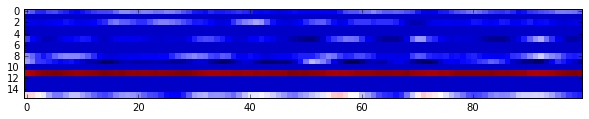

In [38]:
plt.imshow(whitenoise_affine_test[:100,:].T, cmap='seismic')

#### Whitenoise train

In [39]:
for indx, (X, y) in enumerate(datagen(50, *whitenoise_train, shuffle=False)):
    affine_response = white_activations(X)
    whitenoise_affine_train[indx*50:(indx+1)*50,:] = affine_response

#### Naturalscenes test

In [40]:
for indx, (X, y) in enumerate(datagen(50, *naturalscenes_test, shuffle=False)):
    affine_response = natural_activations(X)
    naturalscenes_affine_test[indx*50:(indx+1)*50,:] = affine_response

#### Naturalscenes train

In [41]:
for indx, (X, y) in enumerate(datagen(50, *naturalscenes_train, shuffle=False)):
    affine_response = natural_activations(X)
    naturalscenes_affine_train[indx*50:(indx+1)*50,:] = affine_response

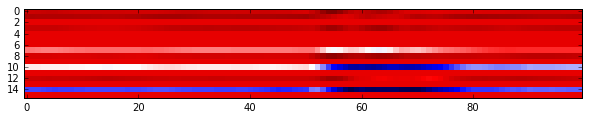

In [42]:
plt.imshow(naturalscenes_affine_train[:100,:].T, cmap='seismic')

# Create new affine stimulus h5 file

#### whitenoise

In [54]:
f = h5py.File('/Users/lmcintosh/experiments/data/15-10-07/whitenoise.h5', 'r')
new_filename = 'whitenoise_affine.h5'
h = h5py.File(new_filename, 'w')

# keep most of the datasets the same
##### spikes #####
ncells = 9
for idx in range(ncells):
    h.create_dataset('spikes/cell%02d' %(idx+1), data=f['spikes/cell%02d' %(idx+1)])
##### train #####
h.create_dataset('train/response/binned', data=f['train/response/binned'][:,40:])
h.create_dataset('train/response/firing_rate_10ms', data=f['train/response/firing_rate_10ms'][:,40:])
h.create_dataset('train/response/firing_rate_20ms', data=f['train/response/firing_rate_20ms'][:,40:])
h.create_dataset('train/response/firing_rate_5ms', data=f['train/response/firing_rate_5ms'][:,40:])
h.create_dataset('train/time', data=f['train/time'][40:])
##### test #####
h.create_dataset('test/response/binned', data=f['test/response/binned'][:,40:])
h.create_dataset('test/response/firing_rate_10ms', data=f['test/response/firing_rate_10ms'][:,40:])
h.create_dataset('test/response/firing_rate_20ms', data=f['test/response/firing_rate_20ms'][:,40:])
h.create_dataset('test/response/firing_rate_5ms', data=f['test/response/firing_rate_5ms'][:,40:])
h.create_dataset('test/time', data=f['test/time'][40:])

# create stimuli datasets
h.create_dataset('train/stimulus', data=whitenoise_affine_train)
h.create_dataset('test/stimulus', data=whitenoise_affine_test)

h.close()
f.close()

#### naturalscenes

In [55]:
f = h5py.File('/Users/lmcintosh/experiments/data/15-10-07/naturalscene.h5', 'r')
new_filename = 'naturalscenes_affine.h5'
h = h5py.File(new_filename, 'w')

# keep most of the datasets the same
##### spikes #####
ncells = 9
for idx in range(ncells):
    h.create_dataset('spikes/cell%02d' %(idx+1), data=f['spikes/cell%02d' %(idx+1)])
##### train #####
h.create_dataset('train/response/binned', data=f['train/response/binned'][:,40:])
h.create_dataset('train/response/firing_rate_10ms', data=f['train/response/firing_rate_10ms'][:,40:])
h.create_dataset('train/response/firing_rate_20ms', data=f['train/response/firing_rate_20ms'][:,40:])
h.create_dataset('train/response/firing_rate_5ms', data=f['train/response/firing_rate_5ms'][:,40:])
h.create_dataset('train/time', data=f['train/time'][40:])
##### test #####
h.create_dataset('test/response/binned', data=f['test/response/binned'][:,40:])
h.create_dataset('test/response/firing_rate_10ms', data=f['test/response/firing_rate_10ms'][:,40:])
h.create_dataset('test/response/firing_rate_20ms', data=f['test/response/firing_rate_20ms'][:,40:])
h.create_dataset('test/response/firing_rate_5ms', data=f['test/response/firing_rate_5ms'][:,40:])
h.create_dataset('test/time', data=f['test/time'][40:])

# create stimuli datasets
h.create_dataset('train/stimulus', data=naturalscenes_affine_train)
h.create_dataset('test/stimulus', data=naturalscenes_affine_test)

h.close()
f.close()